In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [88]:
df_raw = pd.read_csv('churn_data.csv')
print(df_raw.shape)
print(df_raw.CustomerID.nunique())

(5630, 20)
5630


In [89]:
df = df_raw.drop_duplicates()
df = df.set_index('CustomerID')
df.head()

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
CustomerID                                                                  
50001           1     4.0         Mobile Phone         3              6.0   
50002           1     NaN                Phone         1              8.0   
50003           1     NaN                Phone         1             30.0   
50004           1     0.0                Phone         3             15.0   
50005           1     0.0                Phone         1             12.0   

           PreferredPaymentMode  Gender  HourSpendOnApp  \
CustomerID                                                
50001                Debit Card  Female             3.0   
50002                       UPI    Male             3.0   
50003                Debit Card    Male             2.0   
50004                Debit Card    Male             2.0   
50005                        CC    Male             NaN   

            NumberOfDeviceRegistered    PreferedOrderCat  SatisfactionScore  \
CustomerID                                                                    
50001                              3  Laptop & Accessory                  2   
50002                              4              Mobile                  3   
50003                              4              Mobile                  3   
50004                              4  Laptop & Accessory                  5   
50005                              3              Mobile                  5   

           MaritalStatus  NumberOfAddress  Complain  \
CustomerID                                            
50001             Single                9         1   
50002             Single                7         1   
50003             Single                6         1   
50004             Single                8         0   
50005             Single                3         0   

            OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
CustomerID                                                        
50001                              11.0         1.0         1.0   
50002                              15.0         0.0         1.0   
50003                              14.0         0.0         1.0   
50004                              23.0         0.0         1.0   
50005                              11.0         1.0         1.0   

            DaySinceLastOrder  CashbackAmount  
CustomerID                                     
50001                     5.0             160  
50002                     0.0             121  
50003                     3.0             120  
50004                     3.0             134  
50005                     3.0             130

In [90]:
df.isnull().sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [91]:
def counts_func(col):
    value_counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    counts = pd.DataFrame({'Counts': value_counts, 'Percentage': percentages})
    return counts

counts_func('Churn')

Counts  Percentage
0    4682   83.161634
1     948   16.838366

In [92]:
def pct_by_churn(col):
    d_g = df.groupby(col, dropna=False)['Churn'].agg(['mean','count'])
    d_g['%'] = d_g['count']/d_g['count'].sum()
    return d_g

cols = ['PreferredLoginDevice','CityTier','PreferredPaymentMode','HourSpendOnApp',
        'NumberOfDeviceRegistered', 'PreferedOrderCat','SatisfactionScore','MaritalStatus'
        ,'Complain','NumberOfAddress']
for col in cols:
    print(pct_by_churn(col))
    print('##############')

### USE Satisfaction score

                          mean  count         %
PreferredLoginDevice                           
Computer              0.198286   1634  0.290231
Mobile Phone          0.125859   2765  0.491119
Phone                 0.224208   1231  0.218650
##############
              mean  count         %
CityTier                           
1         0.145117   3666  0.651155
2         0.198347    242  0.042984
3         0.213705   1722  0.305861
##############
                          mean  count         %
PreferredPaymentMode                           
CC                    0.216117    273  0.048490
COD                   0.287671    365  0.064831
Cash on Delivery      0.154362    149  0.026465
Credit Card           0.128581   1501  0.266607
Debit Card            0.153846   2314  0.411012
E wallet              0.228013    614  0.109059
UPI                   0.173913    414  0.073535
##############
                    mean  count         %
HourSpendOnApp                           
0.0             0.0

New KPI Ideas:
*  3+ Number of address (or 5+, depending on business goals)
*

NumberOfAddress extremes might be a problem

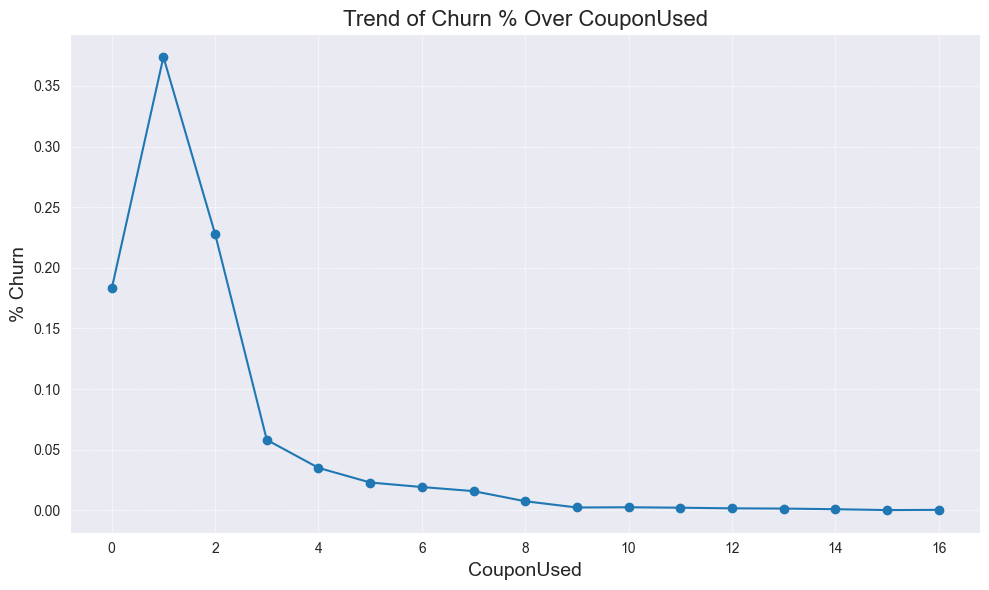

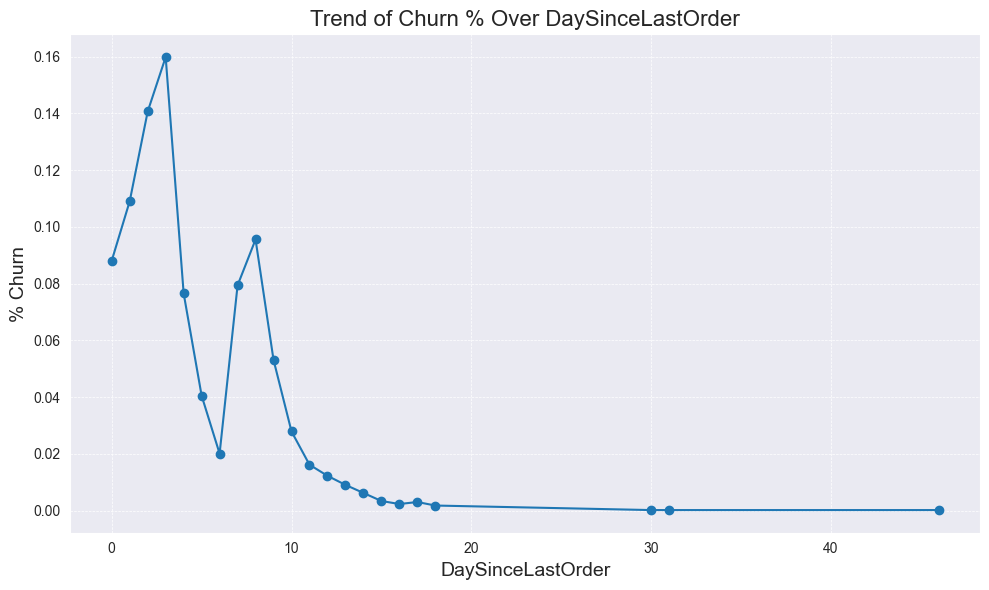

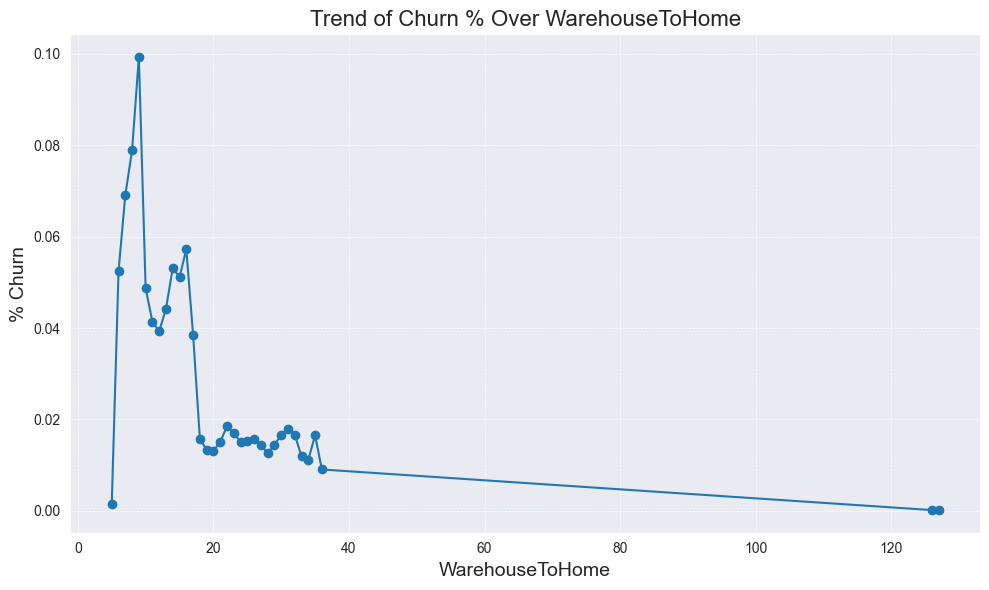

In [93]:
def plt_pct(col):
    d_g = pct_by_churn(col)
    plt.figure(figsize=(10, 6))
    plt.plot(d_g.index, d_g['%'], marker='o', linestyle='-')
    plt.title('Trend of Churn % Over {}'.format(col), fontsize=16)
    plt.xlabel('{}'.format(col), fontsize=14)
    plt.ylabel('% Churn', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plt_pct('Tenure')
### Product -> Engagment
plt_pct('NumberOfAddress')
plt_pct('OrderAmountHikeFromlastYear')
plt_pct('OrderCount')
plt_pct('CouponUsed')
plt_pct('DaySinceLastOrder')
plt_pct('WarehouseToHome')

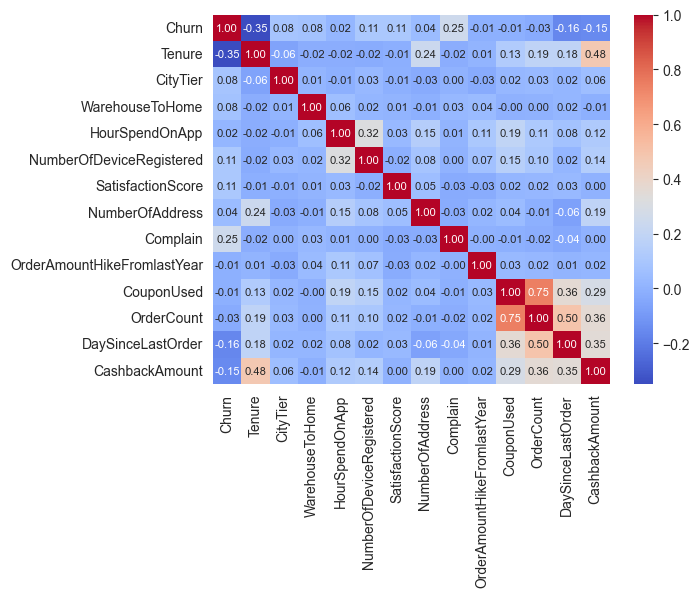

In [94]:
corr = df.select_dtypes('number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size':8})

plt.show()

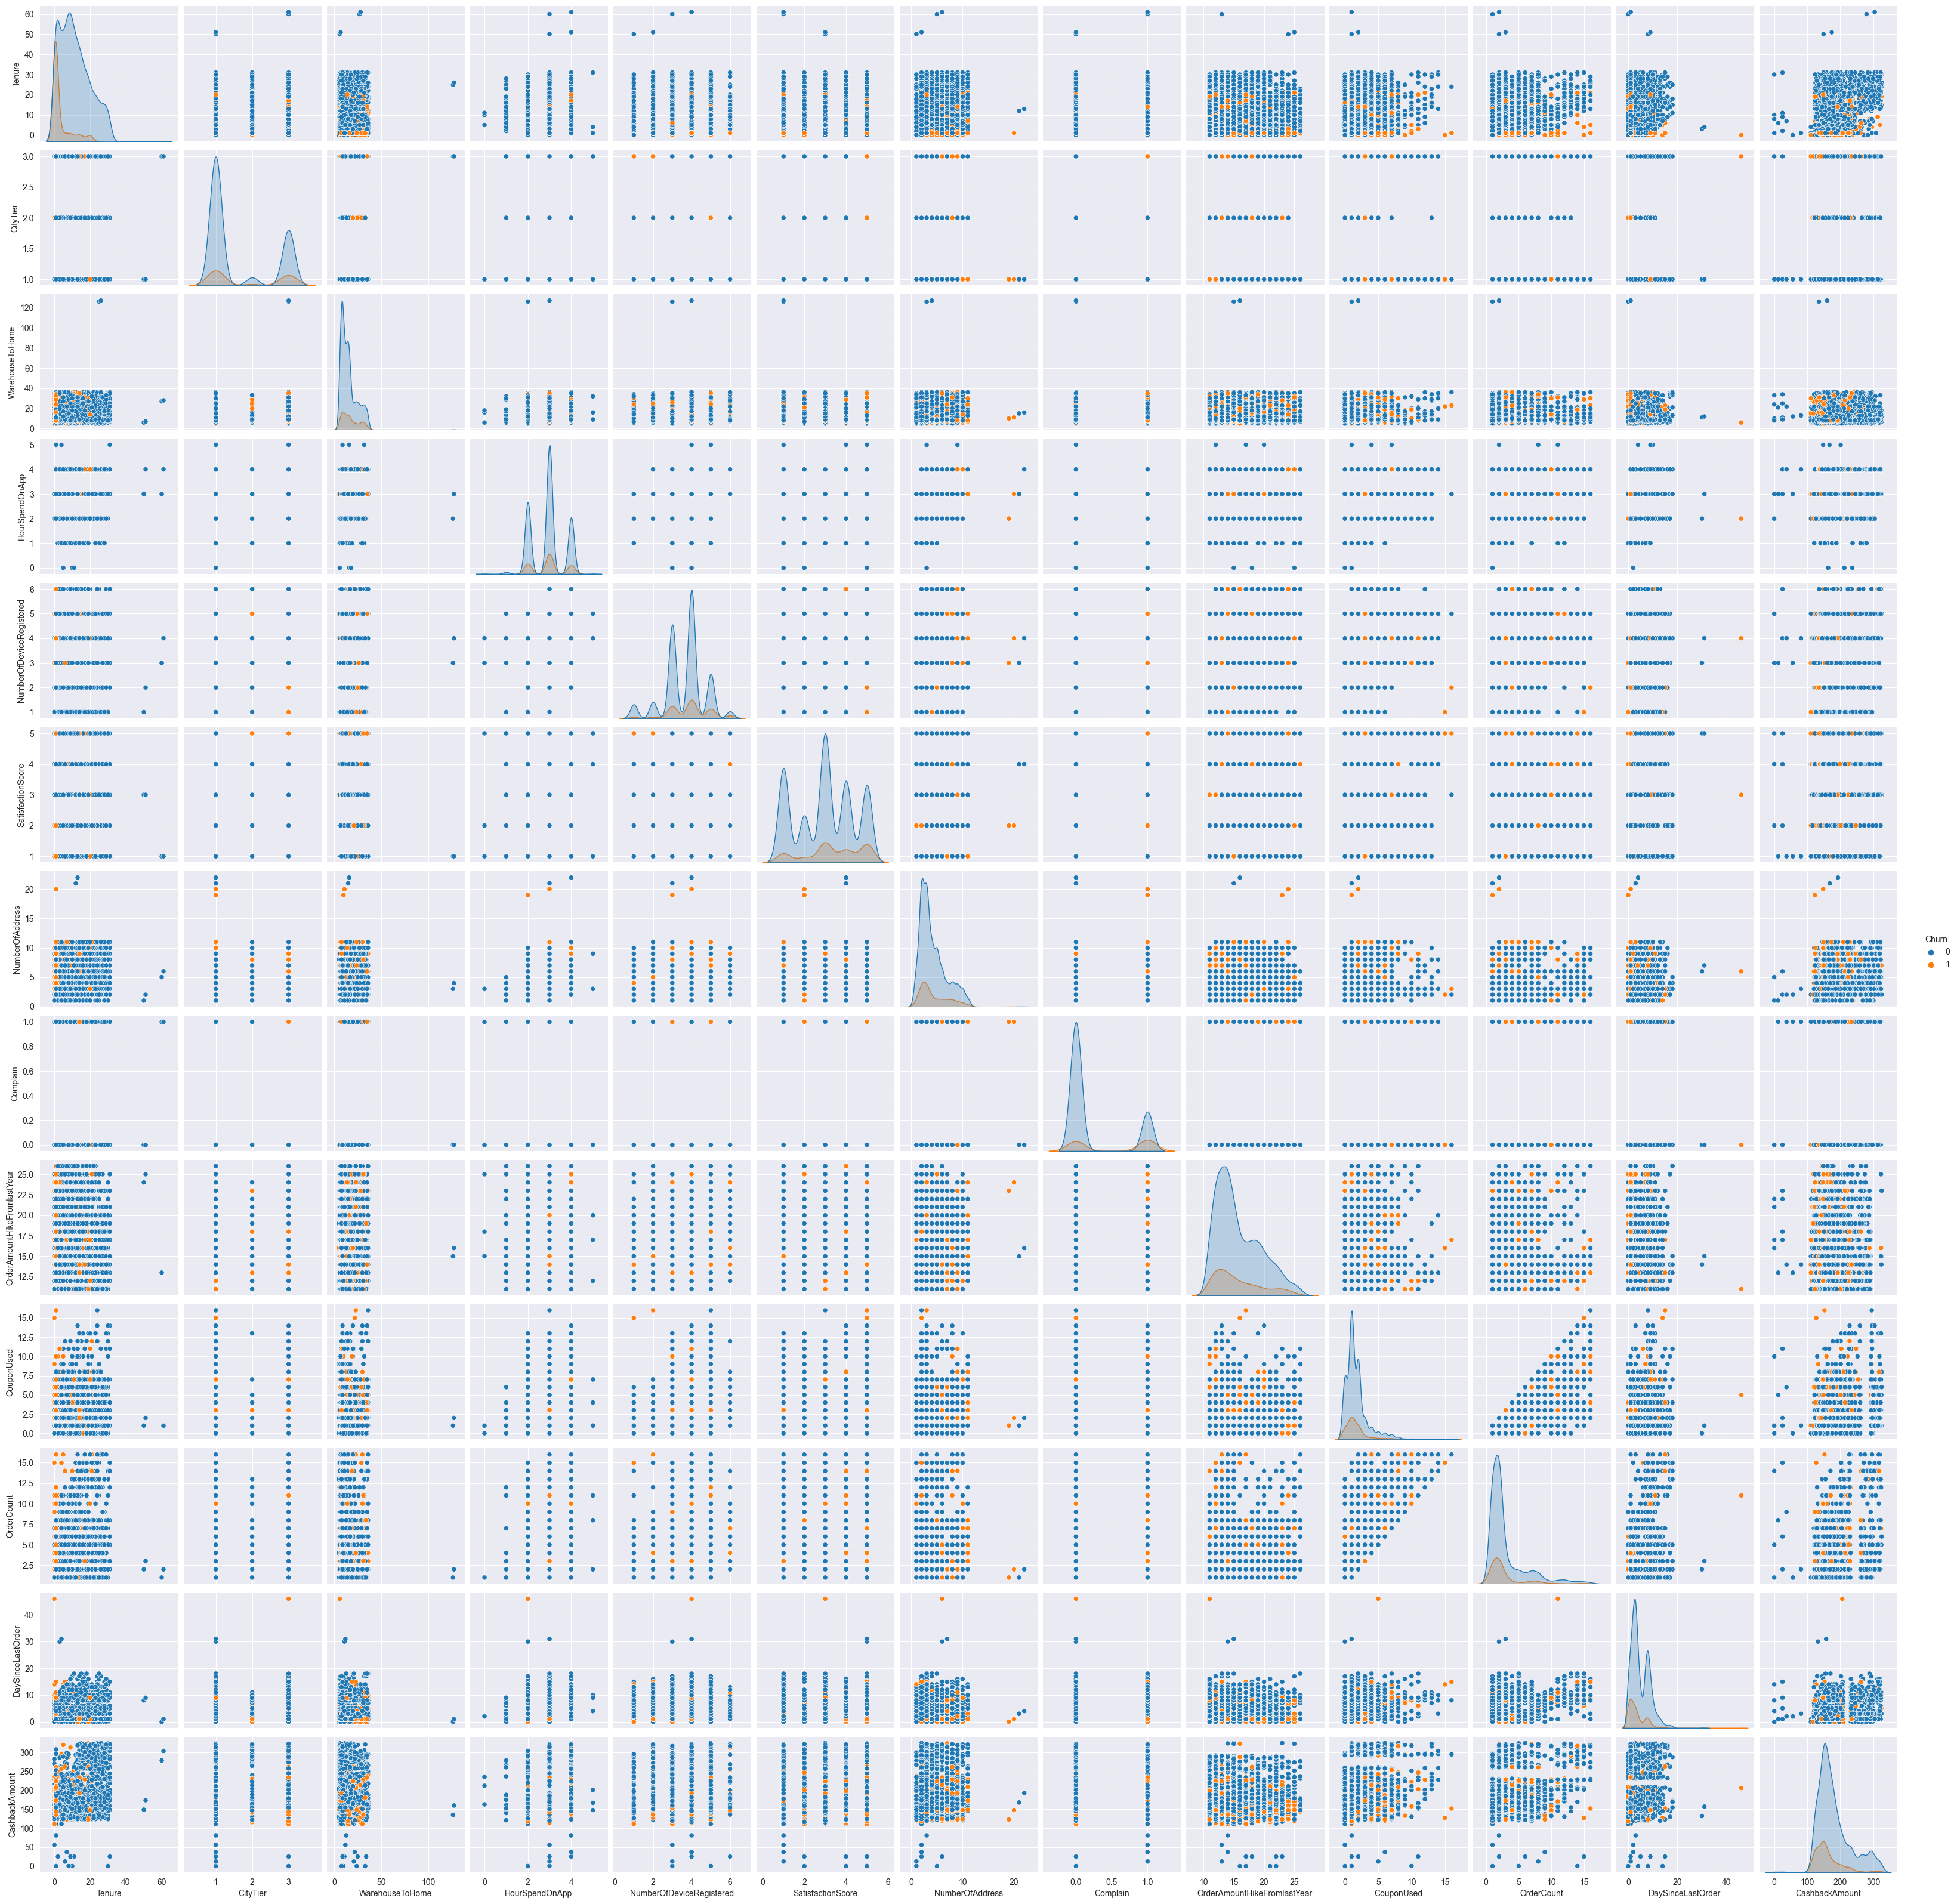

In [95]:
df_pairplot = df.select_dtypes(include=[np.number])
# df_pairplot = df_pairplot.drop(columns=['CouponUsedPct'])
sns.pairplot(df_pairplot,hue='Churn')

* city in the middle, the more the WarehouseToHome, the more churn

* Coupons vs. satisfaction score (In the 0, high amount of coupons high churn, in the 5, (high churn pct.), low amount of coupons.

* bad satisfaction score, last days orders low (looks like 0,1,2), high churn

* High hike from last year, high complains, high churn rate

* High hike, no high coupons, high churn




Text(0.5, 1.0, ' Trend of Churn % Over WarehouseToHome by City Tier ')

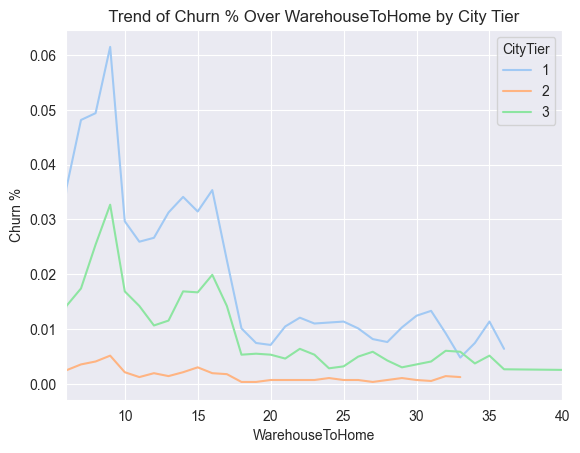

In [96]:
d_g_city = pct_by_churn(['CityTier','WarehouseToHome']).reset_index()

sns.lineplot(x='WarehouseToHome', y='%', data=d_g_city, hue='CityTier',  palette="pastel")
plt.xlim(6,40)
plt.ylabel("Churn %")
plt.title(' Trend of Churn % Over WarehouseToHome by City Tier ')

Text(0.5, 1.0, ' Order Amount Hike over Number of Coupon used by Churn ')

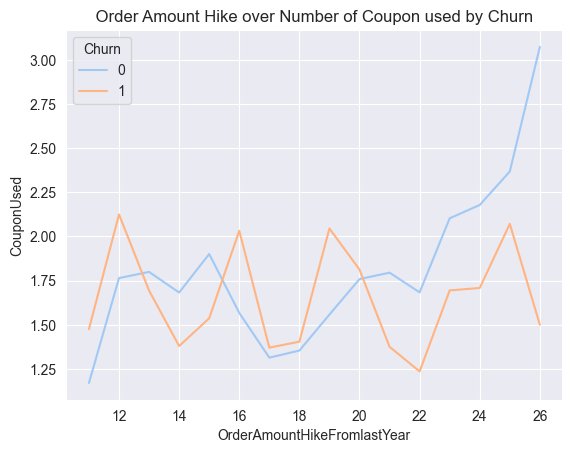

In [97]:
sns.lineplot(x='OrderAmountHikeFromlastYear', y='CouponUsed', data=df, hue='Churn',  palette="pastel",ci=None)

plt.title(' Order Amount Hike over Number of Coupon used by Churn ')

In [98]:
d_g = pct_by_churn(['Complain','OrderAmountHikeFromlastYear']).reset_index()

sns.lineplot(x='OrderAmountHikeFromlastYear', y='%', data=d_g, hue='Complain',  palette="pastel")
plt.xlim(6,40)
plt.ylabel("Churn %")
plt.title(' Trend of Churn % Over WarehouseToHome by City Tier ')

Text(0.5, 1.0, ' Trend of Churn % Over WarehouseToHome by City Tier ')

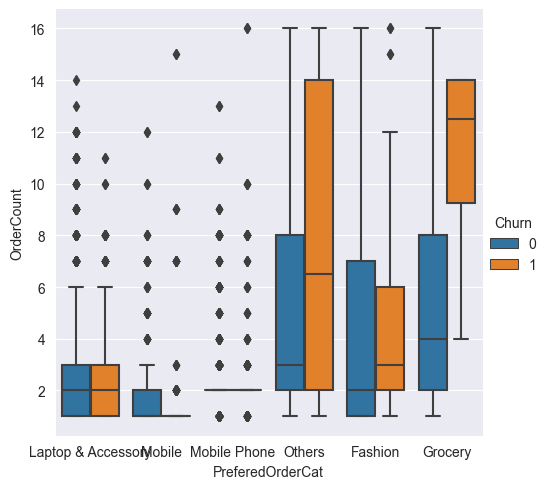

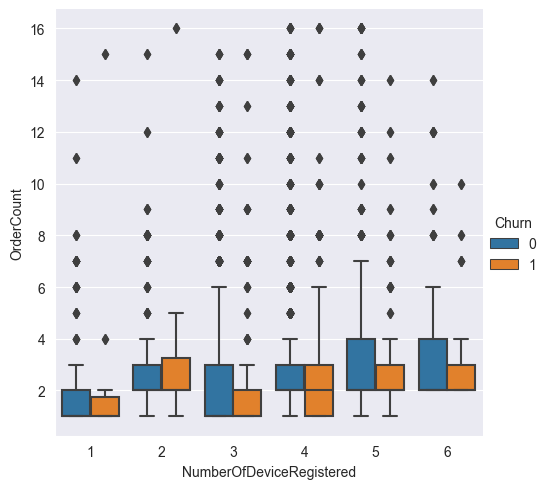

0    4682
1     948
Name: Churn, dtype: int64


In [101]:
# Categorical graphs

sns.catplot(data=df, x="CityTier", y="OrderCount", hue="Churn", kind="box")
plt.show()
sns.catplot(data=df, x="SatisfactionScore", y="OrderCount", hue="Churn", kind="box")
plt.show()
sns.catplot(data=df, x="PreferedOrderCat", y="OrderCount", hue="Churn", kind="box")
plt.show()
sns.catplot(data=df, x="PreferredPaymentMode", y="OrderCount", hue="Churn", kind="box")
plt.show()
sns.catplot(data=df, x="NumberOfDeviceRegistered", y="OrderCount", hue="Churn", kind="box")
plt.show()

print(df.Churn.value_counts())


In [85]:
# cols = ['PreferredLoginDevice','CityTier']
cols = ['SatisfactionScore','Complain']
# df = df[cols].astype(str)
fig, ax = plt.subplots(1, len(cols))
for i, categorical_feature in enumerate(df[cols]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
fig.show()

In [83]:
# cols = ['Churn' ,'PreferredPaymentMode']
# cols = ['PreferedOrderCat','MaritalStatus']
# df = df[cols].astype(str)
fig, ax = plt.subplots(1, len(cols))
for i, categorical_feature in enumerate(df[cols]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
fig.show()
# ['PreferedOrderCat','MaritalStatus']

In [46]:
# Set DTYPES
# print(df.dtypes)
c = ['PreferredLoginDevice','CityTier','SatisfactionScore']
df[c] = df[c].astype(str)

In [47]:
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.dropna()

for col in numeric_df.columns:
    if col not in numeric_df.columns[numeric_df.isin([0,1]).all()]:
        numeric_df[col] = (numeric_df[col] - numeric_df[col].mean())/numeric_df[col].std()


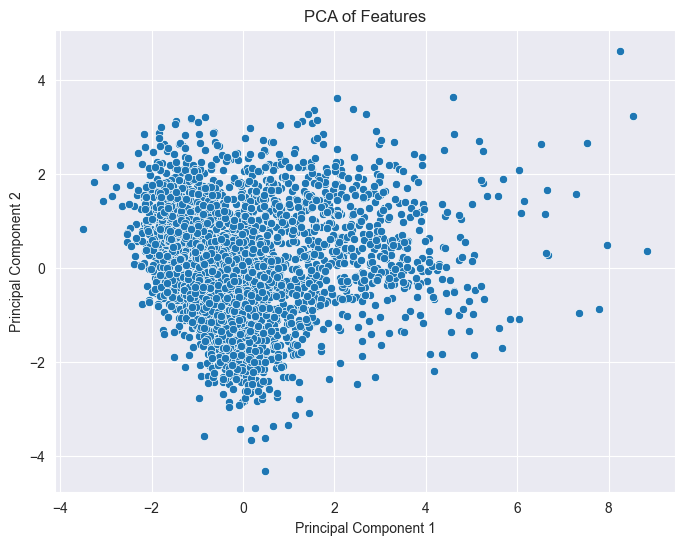

In [48]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(numeric_df)
df_pca = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
df_pca = df_pca[df_pca.notnull()]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features')
plt.show()

* No obvious clusters seen
* Looks like there are some outliers.


IndexError: list index out of range

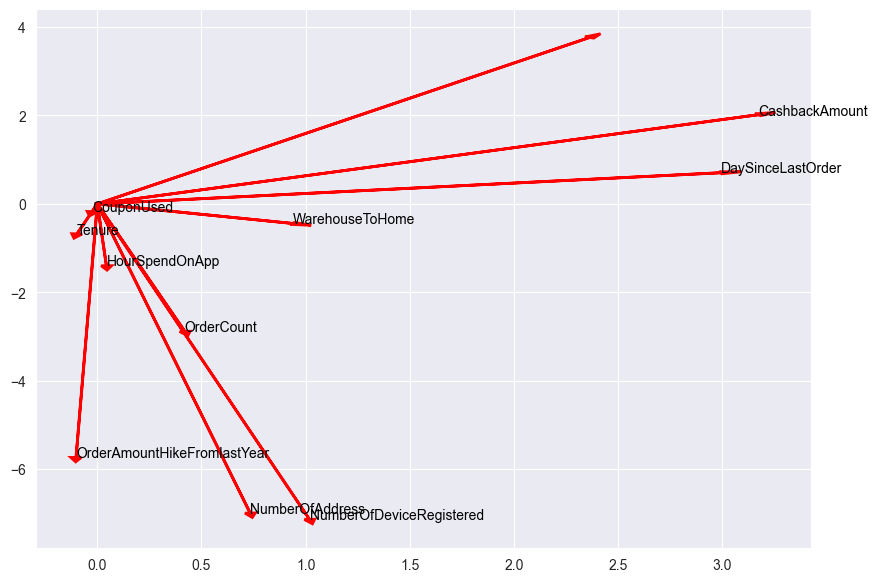

In [72]:
# Plotting the PCA scatter plot
# X_pca = numeric_df.drop(columns='Churn').to_numpy()
col_names = numeric_df.columns.tolist()
# col_names = col_names + ['Churn','Complain']

X_pca = numeric_df.to_numpy()

plt.figure(figsize=(10, 7))

# Plotting the vectors representing the original features
for i, v in enumerate(pca.components_.T):
    plt.arrow(0, 0, v[0]*max(X_pca[:, 0]), v[1]*max(X_pca[:, 1]),
              head_width=0.05, head_length=0.1, linewidth=2, color='red')
    plt.text(v[0]*max(X_pca[:, 0]), v[1]*max(X_pca[:, 1]), str(col_names[i]), color='black')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.grid(True)
plt.show()

3 types of features:
* Location: distance, Address (City,
* Usage:

In [56]:
c = ['Complain','Churn']
df[c] = df[c].astype(str)

In [57]:
# Outliers
cols_numeric = df.select_dtypes(include=np.number).columns.tolist()

for col in df.columns:
    if col in cols_numeric:
        z = np.abs(stats.zscore(df[col]))
        threshold = 3
        outliers = df[z > threshold]
        if not outliers.empty:
            print(col)
            print(outliers[col])
            print('#####')

c = ['Complain','Churn']
df[c] = df[c].astype(int)

CashbackAmount
CustomerID
50102      0
51027      0
51177      0
51256      0
51301     12
52881    325
52917     25
53437    325
53842     25
53992     25
54071     25
54351    325
54907    325
Name: CashbackAmount, dtype: int64
#####


In [58]:
z = np.abs(stats.zscore(df['NumberOfAddress']))
threshold = 3

idx = z[z < threshold].index


df = df.loc[idx]

Check Cashback

In [59]:
plt.hist(df['CashbackAmount'], bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Continuous Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

df['Churn'] = pd.to_numeric(df['Churn'])
print(df.groupby('CashbackAmount')['Churn'].agg({'mean','count'}))

pct_by_churn('CashbackAmount')

                count      mean
CashbackAmount                 
0                   4  0.000000
12                  1  0.000000
25                  4  0.000000
37                  1  0.000000
56                  1  0.000000
...               ...       ...
321                12  0.000000
322                10  0.000000
323                 6  0.333333
324                 6  0.333333
325                 4  0.000000

[220 rows x 2 columns]


mean  count         %
CashbackAmount                           
0               0.000000      4  0.000711
12              0.000000      1  0.000178
25              0.000000      4  0.000711
37              0.000000      1  0.000178
56              0.000000      1  0.000178
...                  ...    ...       ...
321             0.000000     12  0.002133
322             0.000000     10  0.001777
323             0.333333      6  0.001066
324             0.333333      6  0.001066
325             0.000000      4  0.000711

[220 rows x 3 columns]

In [65]:
plt_pct('CashbackAmount')


In [61]:
# Prepare df for modeling feature Importance
num_columns = df.select_dtypes(include=np.number).columns.tolist()
dummies_columns = df.select_dtypes(exclude=np.number).columns.tolist()
dummies_columns = [ele for ele in dummies_columns if ele != 'Churn']

for col in numeric_df.columns:
    if col not in df.columns[df.isin([0,1]).all()]:
        df[col] = (df[col] - df[col].mean())/df[col].std()

df_dum = pd.get_dummies(df,columns=dummies_columns, dtype='int')


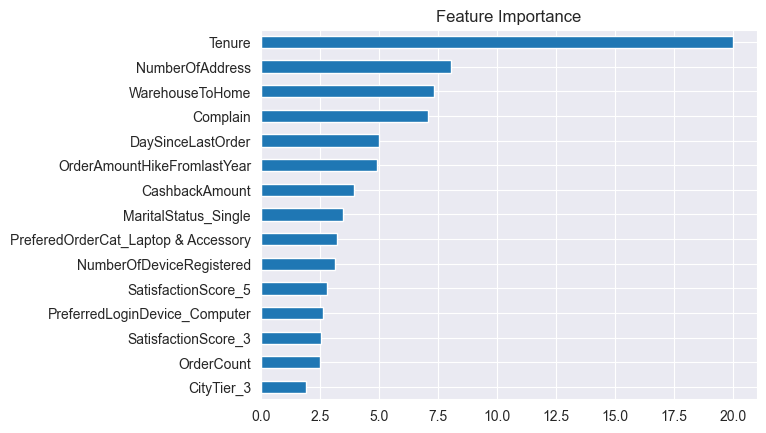

Tenure                                 20.005420
NumberOfAddress                         8.037937
WarehouseToHome                         7.332782
Complain                                7.104046
DaySinceLastOrder                       5.023990
OrderAmountHikeFromlastYear             4.909217
CashbackAmount                          3.943146
MaritalStatus_Single                    3.485423
PreferedOrderCat_Laptop & Accessory     3.242644
NumberOfDeviceRegistered                3.162067
SatisfactionScore_5                     2.801636
PreferredLoginDevice_Computer           2.631843
SatisfactionScore_3                     2.572807
OrderCount                              2.498092
CityTier_3                              1.898470
SatisfactionScore_1                     1.872648
Gender_Male                             1.802289
SatisfactionScore_4                     1.775091
CityTier_1                              1.651762
PreferedOrderCat_Fashion                1.550676
PreferredPaymentMode

In [64]:
# Feature Importance
def feature_selection(df, col, n_select_features=None):
    if n_select_features is None:
        n_select_features = df.shape[1]
    model = CatBoostClassifier(logging_level='Silent')

    X = df.drop(columns=col)
    y = df[col]

    model.fit(X, y)

    feat_imp = model.feature_importances_

    feature_importance_df = pd.Series(feat_imp, index=X.columns)
    feature_importance_df = feature_importance_df.sort_values(ascending=False)
    feature_importance_df = feature_importance_df[0:n_select_features]

    return feature_importance_df, model

df_feat_sel, model_selection = feature_selection(df_dum,'Churn')

df_feat_sel.nlargest(15).sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance')
plt.show()


print(df_feat_sel[df_feat_sel>1])

In [105]:
similarity_matrix = cosine_similarity(numeric_df)

# Find indices of most similar pairs
most_similar_pairs = []
max_similarity = -1
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        similarity = similarity_matrix[i][j]
        if similarity > max_similarity:
            most_similar_pairs = [(i, j)]
            max_similarity = similarity
        elif similarity == max_similarity:
            most_similar_pairs.append((i, j))

# Print most similar pairs
for pair in most_similar_pairs:
    print("Similar rows:", pair, "with similarity:", max_similarity)
    print("Row", pair[0], ":", df.iloc[pair[0]])
    print("Row", pair[1], ":", df.iloc[pair[1]])

Similar rows: (8, 837) with similarity: 1.0000000000000004
Row 8 : Churn                                 1
Tenure                             13.0
PreferredLoginDevice              Phone
CityTier                              3
WarehouseToHome                     9.0
PreferredPaymentMode           E wallet
Gender                             Male
HourSpendOnApp                      NaN
NumberOfDeviceRegistered              4
PreferedOrderCat                 Mobile
SatisfactionScore                     3
MaritalStatus                  Divorced
NumberOfAddress                       2
Complain                              1
OrderAmountHikeFromlastYear        14.0
CouponUsed                          0.0
OrderCount                          1.0
DaySinceLastOrder                   2.0
CashbackAmount                      127
Name: 50009, dtype: object
Row 837 : Churn                                     0
Tenure                                 24.0
PreferredLoginDevice           Mobile Phone
City